In [1]:
!pip install segmentation-models-pytorch -U albumentations

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.5/109.5 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 42.8 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.9/227.9 kB 13.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 606.4/606.4 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 291.7/291.7 kB 16.2 MB/s eta 0:00:00
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16427 sha256=a80509d5cebfecd2edd45899c7228b013d756279912ae01eb32acfffc50dc32e
  Stored in dir

In [2]:
! nvidia-smi

Sun Nov 24 15:10:06 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P0             26W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
import os
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

from torchvision.transforms import ToTensor
from PIL import Image
import os

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision 
from torchvision import transforms
from torchinfo import summary

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


# Data processing

In [4]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dir, label_dir, resize=None, transform=None):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.resize = resize
        self.transform = transform
        self.images = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.images)
    
    def read_mask(self, mask_path):
        image = cv2.imread(mask_path)
        image = cv2.resize(image, self.resize)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

        lower1 = np.array([0, 100, 20])
        upper1 = np.array([10, 255, 255])

        lower2 = np.array([160,100,20])
        upper2 = np.array([179,255,255])
        lower_mask = cv2.inRange(image, lower1, upper1)
        upper_mask = cv2.inRange(image, lower2, upper2)
        
        red_mask = lower_mask + upper_mask;
        red_mask[red_mask != 0] = 1

        green_mask = cv2.inRange(image, (36, 25, 25), (70, 255, 255))
        green_mask[green_mask != 0] = 2

        full_mask = cv2.bitwise_or(red_mask, green_mask)
        full_mask = np.expand_dims(full_mask, axis=-1) 
        full_mask = full_mask.astype(np.uint8)
        
        return full_mask

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = cv2.imread(img_path)  # Đọc ảnh dưới dạng BGR
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert sang RGB
        label = self.read_mask(label_path)  
        image = cv2.resize(image, self.resize)
        if self.transform:
            image = self.transform(image)
            
        return image, label

    def show_image(self, idx):
        img_path = os.path.join(self.img_dir, self.images[idx])
        label_path = os.path.join(self.label_dir, self.images[idx])
        image = plt.imread(img_path)
        label = plt.imread(label_path)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title('Image')
        axs[1].imshow(label)
        axs[1].set_title('Label')
        plt.show()

# Data visualization

In [5]:
# take the root train and train_gt folder
data_train_path = "/kaggle/input/polyps-bkai/train/train" # for image
data_train_gt_path = "/kaggle/input/polyps-bkai/train_gt/train_gt" # for lable
 
# get the files inside train and train_gt folder
train_image_name_list = os.listdir(data_train_path)
train_lable_name_list = os.listdir(data_train_gt_path)

# dir list of image and lable taken from train and train_gt folder
train_image_dirs = [os.path.join(data_train_path,train_image_file) for train_image_file in train_image_name_list]
train_lable_dirs = [os.path.join(data_train_gt_path,train_lable_file) for train_lable_file in train_lable_name_list]

print("number_of_image: ", len(train_image_dirs))
print("number_of_lable: ", len(train_lable_dirs))


number_of_image:  1000
number_of_lable:  1000


In [6]:

dataset = CustomImageDataset(img_dir= data_train_path,
                             label_dir= data_train_gt_path,
                             resize= (256,256),
                             transform = None)

# Model

In [7]:
import segmentation_models_pytorch as smp

In [8]:
model = smp.UnetPlusPlus(
    encoder_name="resnet34",        
    encoder_weights="imagenet",     
    in_channels=3,                  
    classes=3)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 375MB/s]


In [9]:
BATCH_SIZE = 8
images_data, labels_data = [], []
for x,y in dataset:
    images_data.append(x)
    labels_data.append(y)

# Tranformation, Train, Validation

In [10]:
class CustomDataset(CustomImageDataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        image = self.data[index]
        label = self.targets[index]
        if self.transform:
            transformed = self.transform(image=image, mask=label)
            image = transformed['image'].float()
            label = transformed['mask'].float()
            label = label.permute(2, 0, 1)
        return image, label
    
    def __len__(self):
        return len(self.data)

    
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomGamma (gamma_limit=(70, 130), always_apply=False, p=0.2),
    A.RGBShift(p=0.3, r_shift_limit=10, g_shift_limit=10, b_shift_limit=10),
    # A.ToFloat(max_value=255),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_size = int(0.9 * len(images_data))
val_size = len(images_data) - train_size
train_dataset = CustomDataset(images_data[:train_size], labels_data[:train_size], transform=train_transform)
val_dataset = CustomDataset(images_data[train_size:], labels_data[train_size:], transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(len(train_dataset))
print(len(val_dataset))

900
100


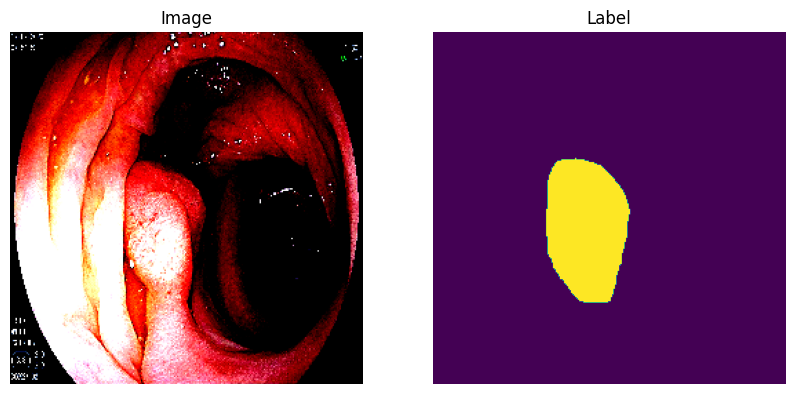

In [11]:
image,label = train_dataset[20]

label_array = label.permute(1, 2, 0).numpy()
image_array = image.permute(1, 2, 0).numpy()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(image_array)
axs[0].set_title('Image')
axs[0].axis('off')  

axs[1].imshow(label_array)
axs[1].set_title('Label')
axs[1].axis('off')  

plt.show()

# Base setup

In [12]:
NUM_EPOCHS = 150
LEARNING_RATE = 0.0001
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer

In [13]:
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [14]:
color_dict= {0: (0, 0, 0),
             1: (255, 0, 0),
             2: (0, 255, 0)}
def mask_to_rgb(mask, color_dict):
    output = np.zeros((mask.shape[0], mask.shape[1], 3))

    for k in color_dict.keys():
        output[mask==k] = color_dict[k]

    return np.uint8(output)

# Wandb

In [15]:
!pip install wandb
import wandb

In [16]:
# ! wandb login "10a2c0921307e4b38882cec4b285ddf098953e3c"
PROJECT = 'Unet_polyp-Segmentation'
RESUME = "allow"
WANDB_KEY = "10a2c0921307e4b38882cec4b285ddf098953e3c"

In [17]:
wandb.init(
    project = PROJECT,
    resume=RESUME,
    config={
        "learning_rate": LEARNING_RATE,
        "epochs": NUM_EPOCHS,
    },
)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch [1/150] |         Train_loss: 0.7342643131 |         Train_accuracy: 0.2632566325 |         Val_loss: 0.4020362817 |         Val_accuracy: 0.3241512044
New best checkpoint saved!


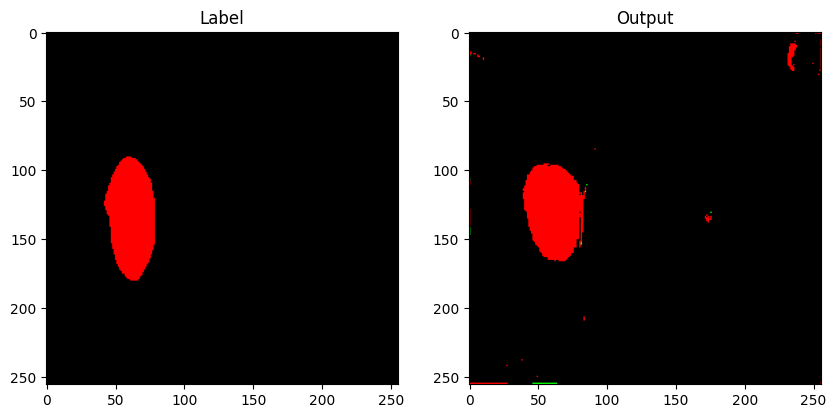

Epoch [2/150] |         Train_loss: 0.3070081404 |         Train_accuracy: 0.3244123897 |         Val_loss: 0.2257826133 |         Val_accuracy: 0.3261416626
New best checkpoint saved!


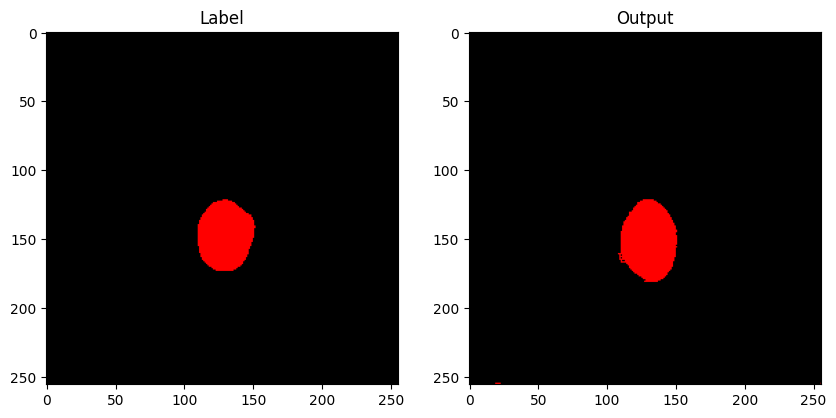

Epoch [3/150] |         Train_loss: 0.1854136880 |         Train_accuracy: 0.3262584771 |         Val_loss: 0.1500740212 |         Val_accuracy: 0.3271712748
New best checkpoint saved!


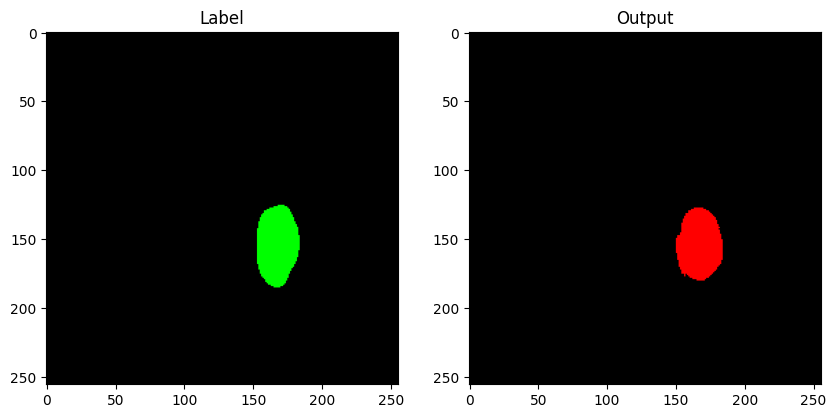

Epoch [4/150] |         Train_loss: 0.1266396598 |         Train_accuracy: 0.3276261280 |         Val_loss: 0.1133600342 |         Val_accuracy: 0.3275623576
New best checkpoint saved!


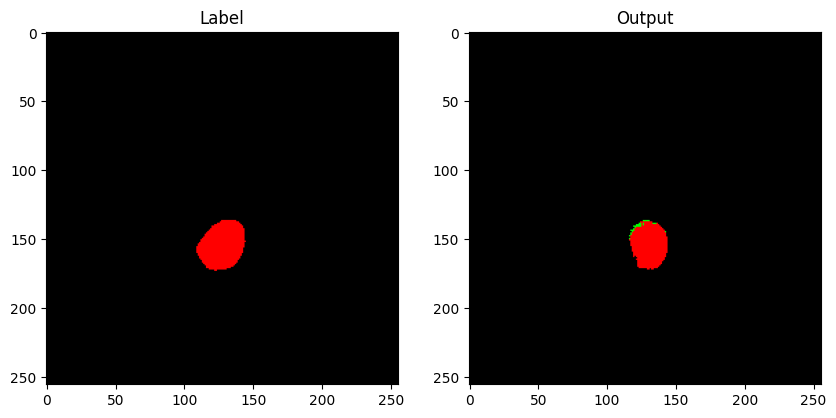

Epoch [5/150] |         Train_loss: 0.0992020268 |         Train_accuracy: 0.3278706190 |         Val_loss: 0.0924727659 |         Val_accuracy: 0.3277323914
New best checkpoint saved!


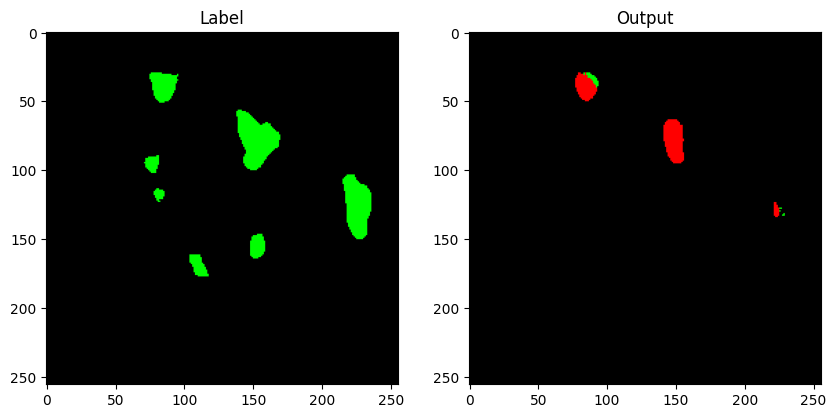

Epoch [6/150] |         Train_loss: 0.0814798585 |         Train_accuracy: 0.3282442559 |         Val_loss: 0.0820151034 |         Val_accuracy: 0.3280235291
New best checkpoint saved!


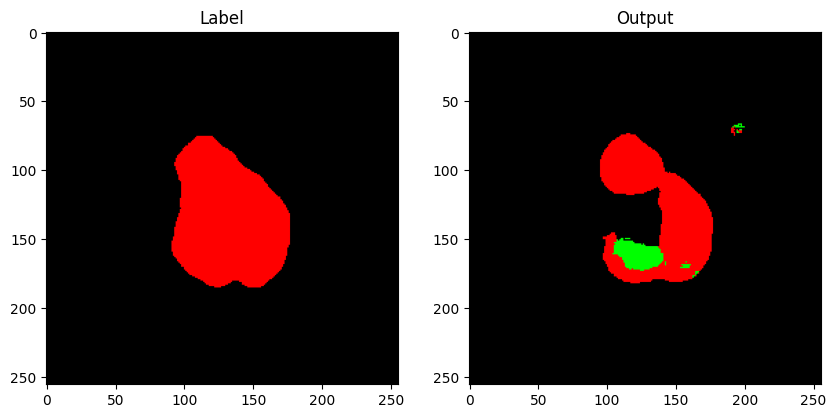

Epoch [7/150] |         Train_loss: 0.0690560968 |         Train_accuracy: 0.3286226230 |         Val_loss: 0.0749154916 |         Val_accuracy: 0.3285712179
New best checkpoint saved!


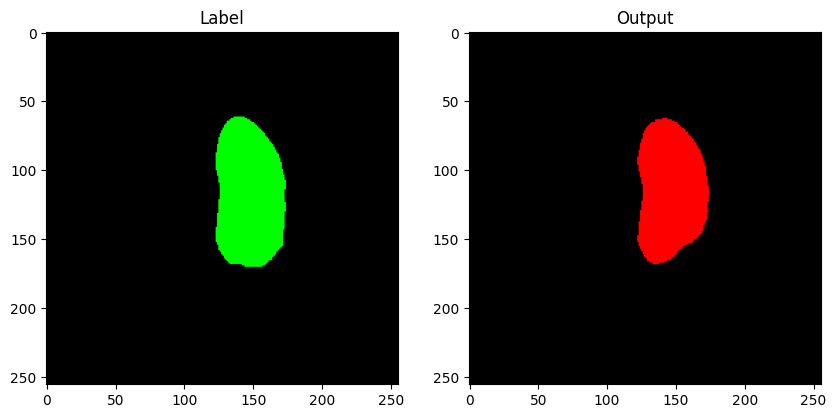

Epoch [8/150] |         Train_loss: 0.0565331451 |         Train_accuracy: 0.3293511341 |         Val_loss: 0.0665116207 |         Val_accuracy: 0.3283198039
New best checkpoint saved!


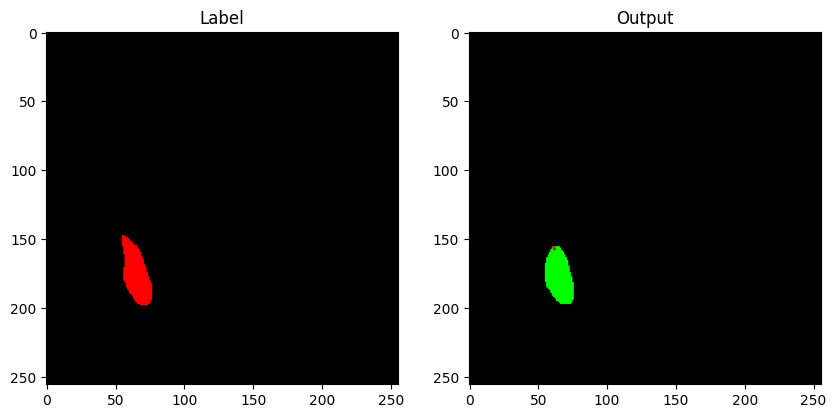

Epoch [9/150] |         Train_loss: 0.0505320241 |         Train_accuracy: 0.3296175526 |         Val_loss: 0.0645746960 |         Val_accuracy: 0.3283795675
New best checkpoint saved!


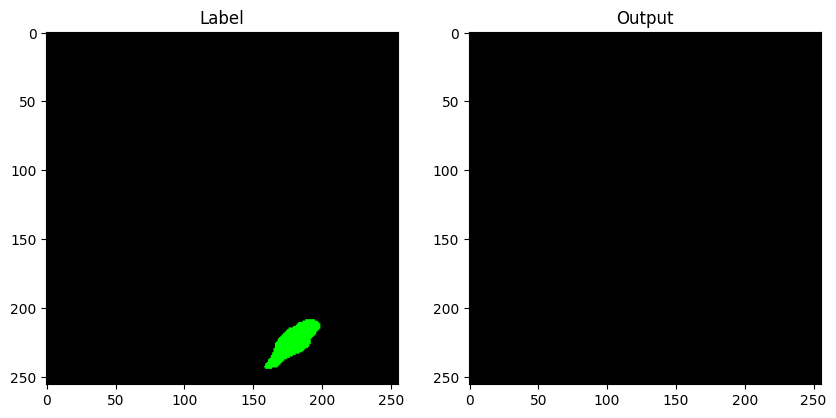

Epoch [10/150] |         Train_loss: 0.0437099824 |         Train_accuracy: 0.3299950946 |         Val_loss: 0.0601868321 |         Val_accuracy: 0.3289244080
New best checkpoint saved!


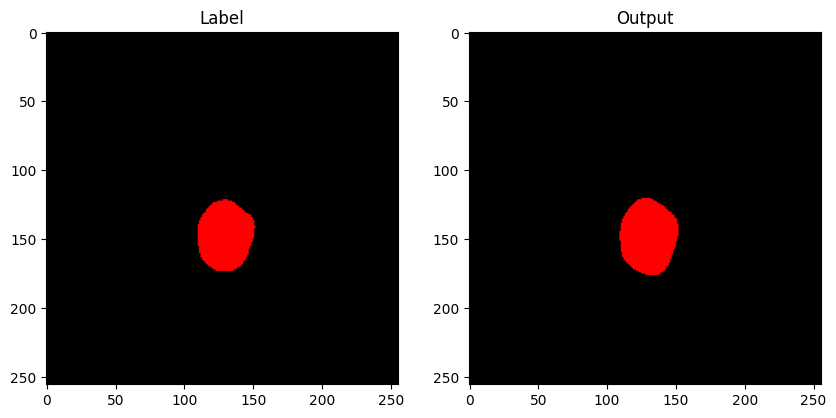

Epoch [11/150] |         Train_loss: 0.0414277076 |         Train_accuracy: 0.3300044872 |         Val_loss: 0.0577177312 |         Val_accuracy: 0.3286269633
New best checkpoint saved!


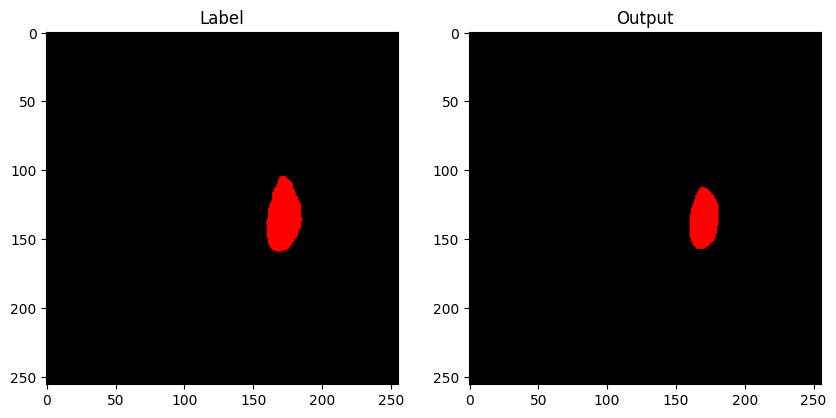

Epoch [12/150] |         Train_loss: 0.0415119397 |         Train_accuracy: 0.3296872570 |         Val_loss: 0.0588961115 |         Val_accuracy: 0.3279217529


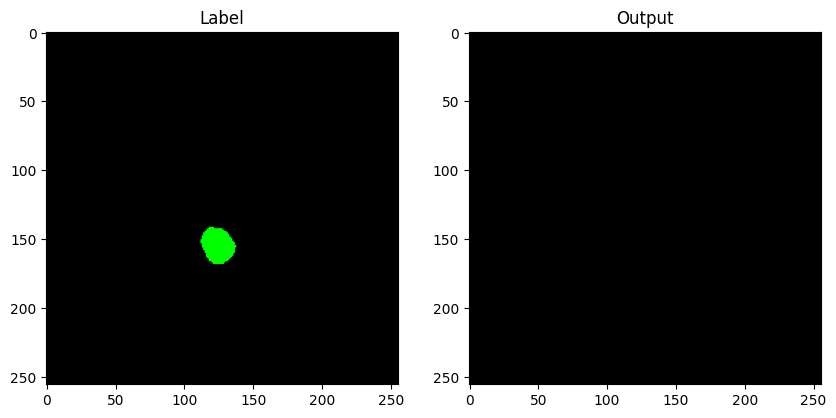

Epoch [13/150] |         Train_loss: 0.0398855046 |         Train_accuracy: 0.3298895207 |         Val_loss: 0.0613144443 |         Val_accuracy: 0.3281100464


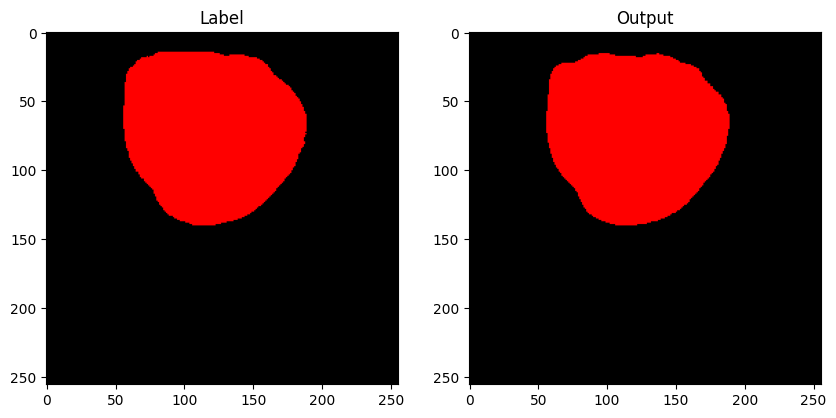

Epoch [14/150] |         Train_loss: 0.0334425383 |         Train_accuracy: 0.3303728683 |         Val_loss: 0.0525473445 |         Val_accuracy: 0.3289401754
New best checkpoint saved!


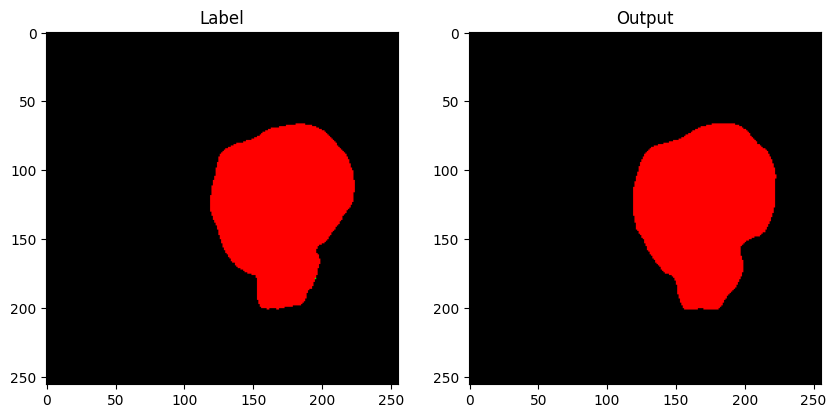

Epoch [15/150] |         Train_loss: 0.0313063411 |         Train_accuracy: 0.3305833831 |         Val_loss: 0.0521553867 |         Val_accuracy: 0.3290846761
New best checkpoint saved!


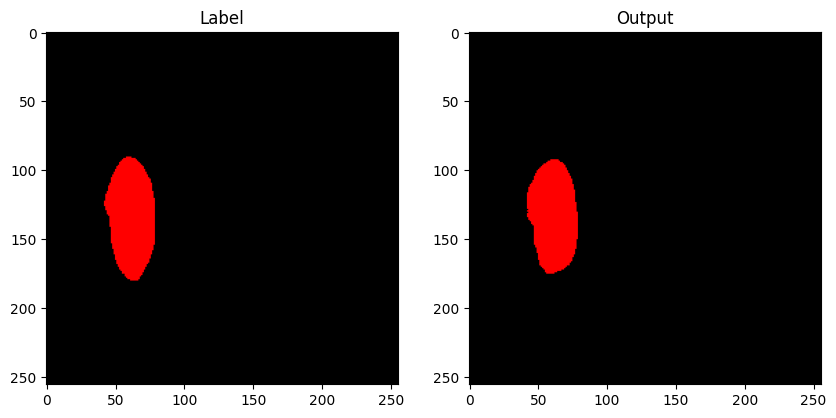

Epoch [16/150] |         Train_loss: 0.0295299063 |         Train_accuracy: 0.3306534435 |         Val_loss: 0.0545467250 |         Val_accuracy: 0.3277701823


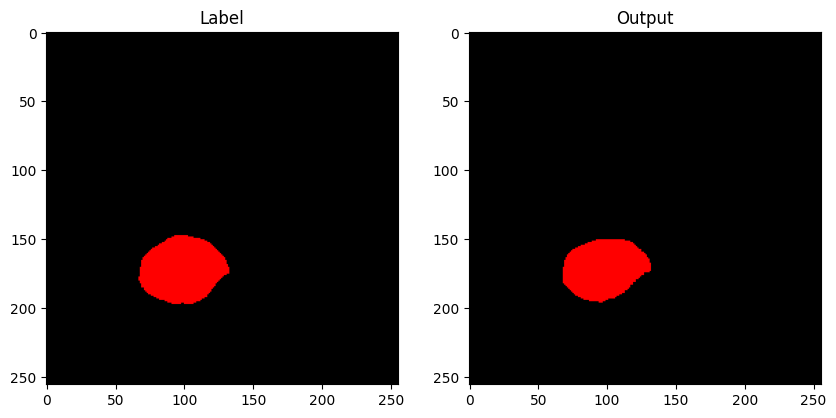

Epoch [17/150] |         Train_loss: 0.0283173190 |         Train_accuracy: 0.3307585031 |         Val_loss: 0.0530440011 |         Val_accuracy: 0.3284243774


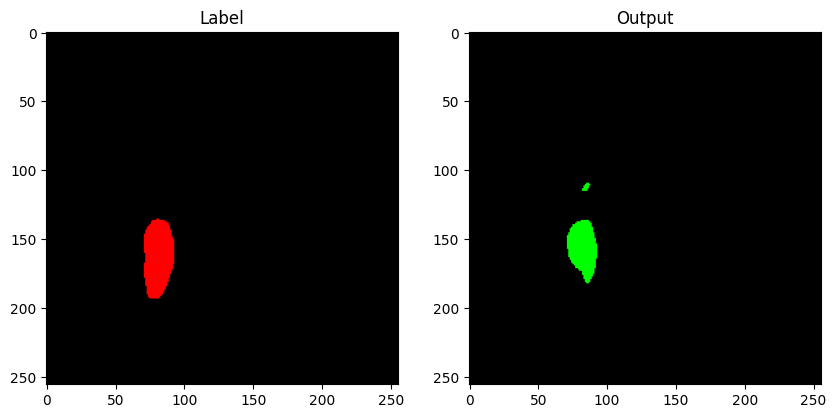

Epoch [18/150] |         Train_loss: 0.0251978755 |         Train_accuracy: 0.3311106081 |         Val_loss: 0.0517158515 |         Val_accuracy: 0.3289145406
New best checkpoint saved!


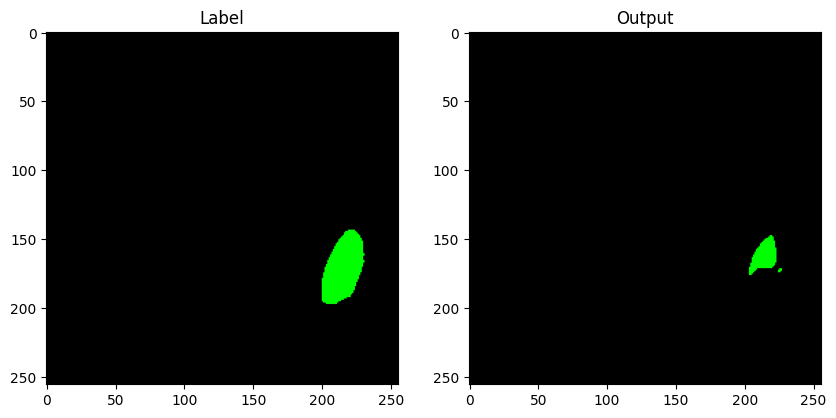

Epoch [19/150] |         Train_loss: 0.0248550010 |         Train_accuracy: 0.3309430271 |         Val_loss: 0.0520311164 |         Val_accuracy: 0.3290786743


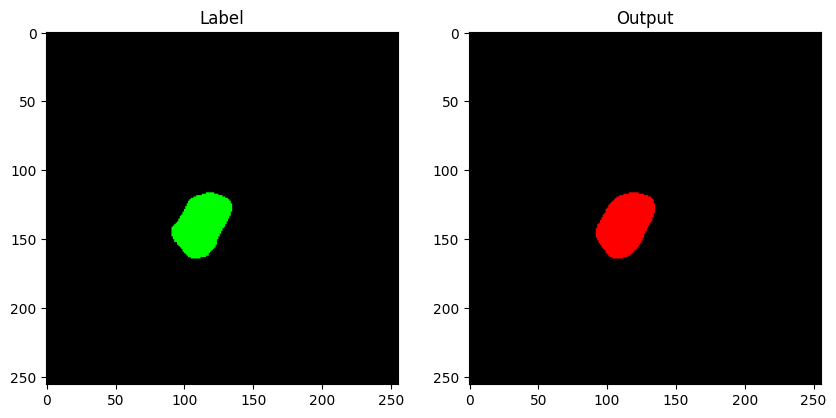

Epoch [20/150] |         Train_loss: 0.0207253442 |         Train_accuracy: 0.3313923589 |         Val_loss: 0.0542193049 |         Val_accuracy: 0.3291862488


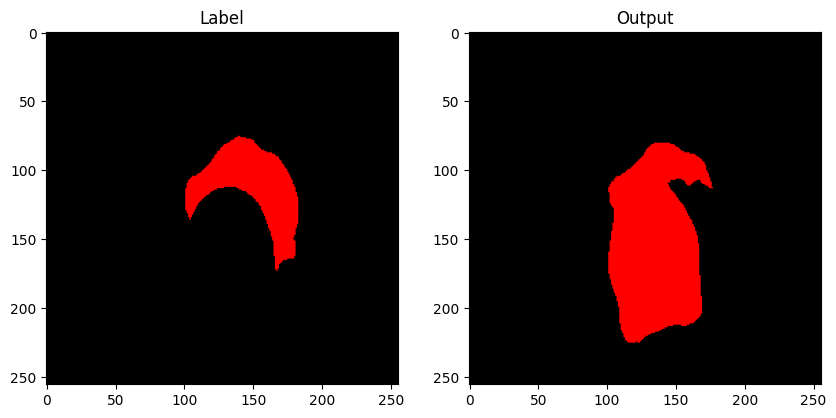

Epoch [21/150] |         Train_loss: 0.0190261349 |         Train_accuracy: 0.3315927689 |         Val_loss: 0.0517945185 |         Val_accuracy: 0.3290316772


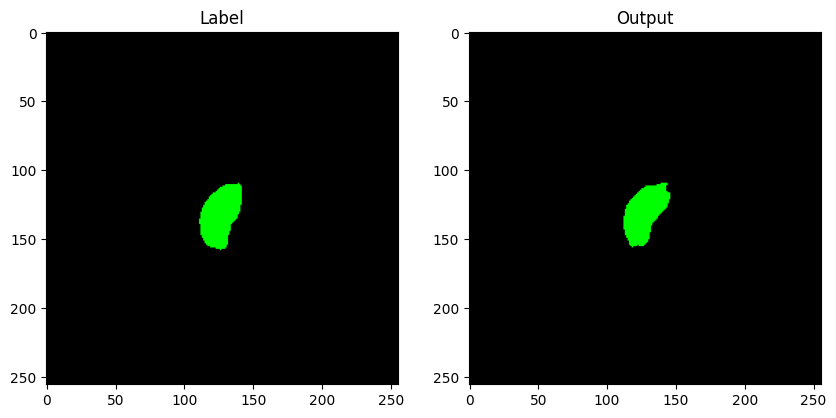

Epoch [22/150] |         Train_loss: 0.0174130137 |         Train_accuracy: 0.3316893571 |         Val_loss: 0.0515057303 |         Val_accuracy: 0.3294560750
New best checkpoint saved!


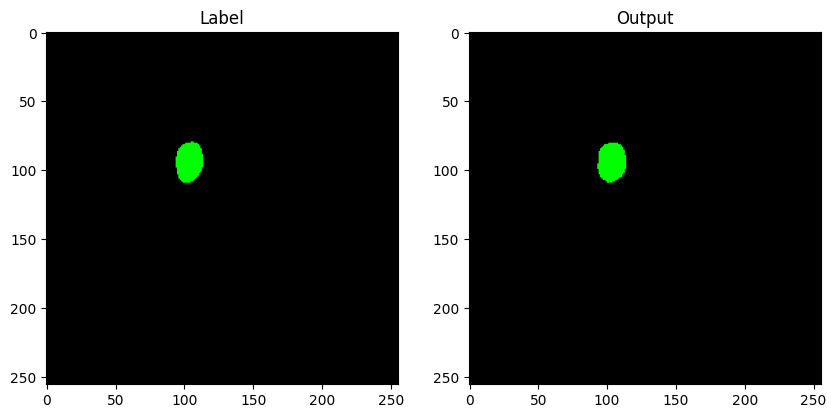

Epoch [23/150] |         Train_loss: 0.0177070357 |         Train_accuracy: 0.3316465477 |         Val_loss: 0.0480180783 |         Val_accuracy: 0.3293175761
New best checkpoint saved!


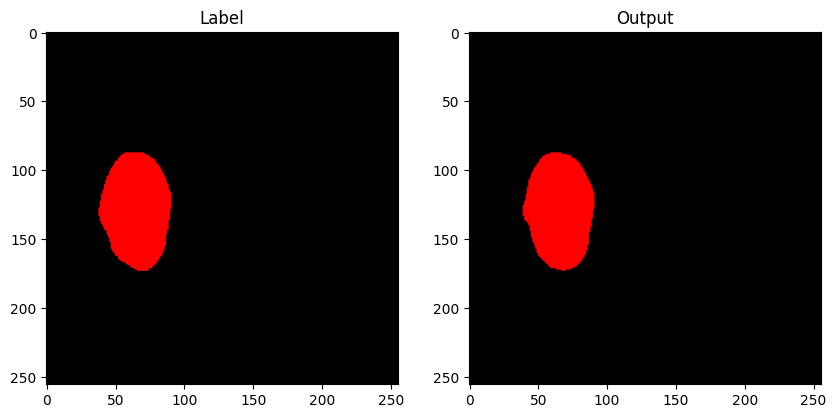

Epoch [24/150] |         Train_loss: 0.0173549868 |         Train_accuracy: 0.3316660450 |         Val_loss: 0.0620373228 |         Val_accuracy: 0.3288773092


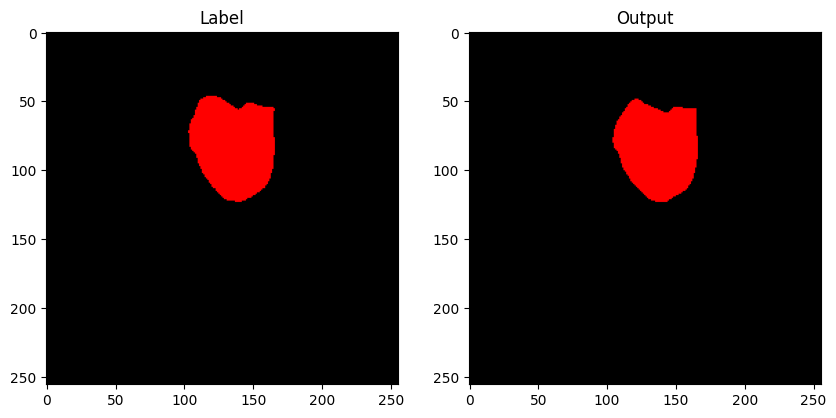

Epoch [25/150] |         Train_loss: 0.0205675316 |         Train_accuracy: 0.3312640155 |         Val_loss: 0.0626962248 |         Val_accuracy: 0.3281416321


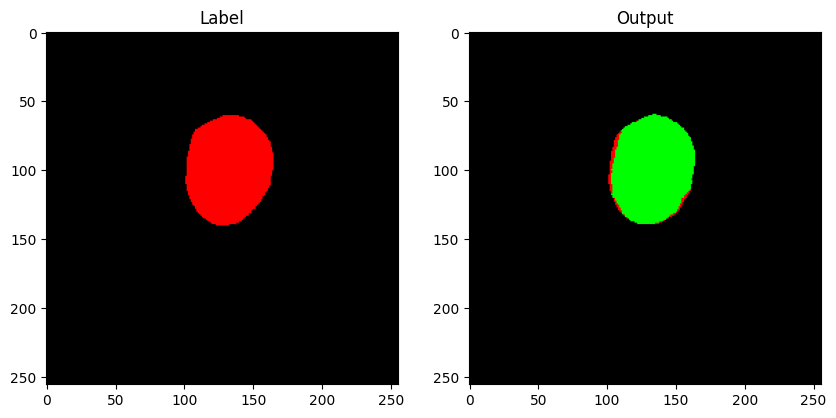

Epoch [26/150] |         Train_loss: 0.0171129025 |         Train_accuracy: 0.3316145890 |         Val_loss: 0.0525645134 |         Val_accuracy: 0.3293395996


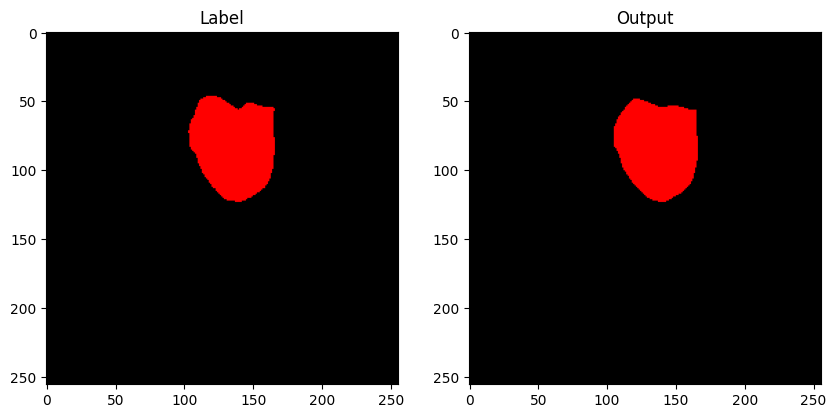

Epoch [27/150] |         Train_loss: 0.0189603426 |         Train_accuracy: 0.3314139416 |         Val_loss: 0.0517806086 |         Val_accuracy: 0.3289897156


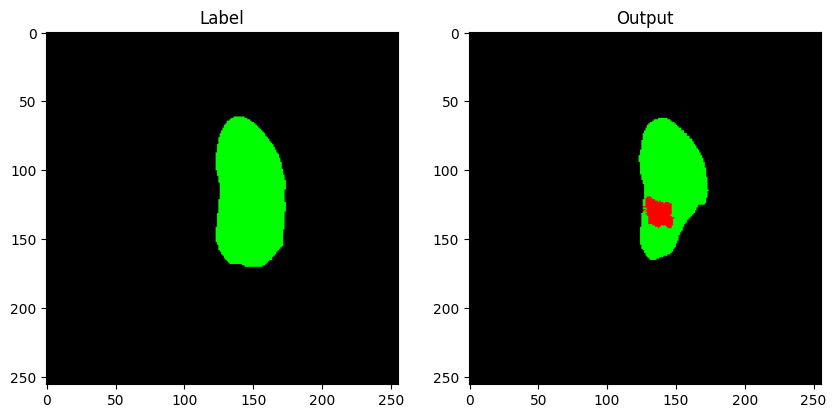

Epoch [28/150] |         Train_loss: 0.0240647724 |         Train_accuracy: 0.3307331905 |         Val_loss: 0.0662741025 |         Val_accuracy: 0.3278141785


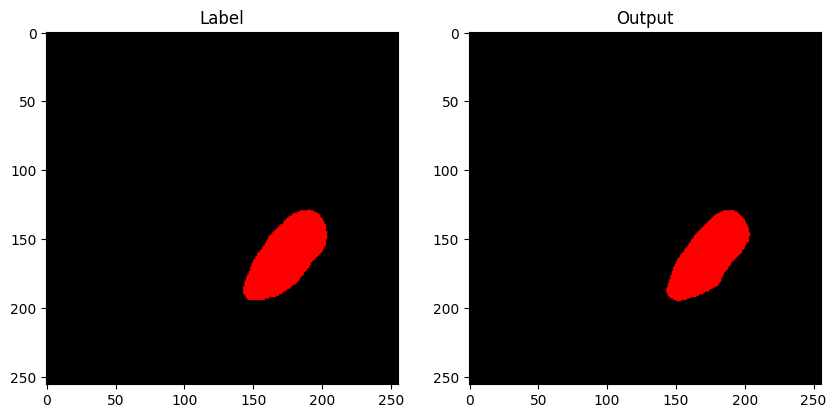

Epoch [29/150] |         Train_loss: 0.0212895145 |         Train_accuracy: 0.3310893306 |         Val_loss: 0.0578845042 |         Val_accuracy: 0.3280592855


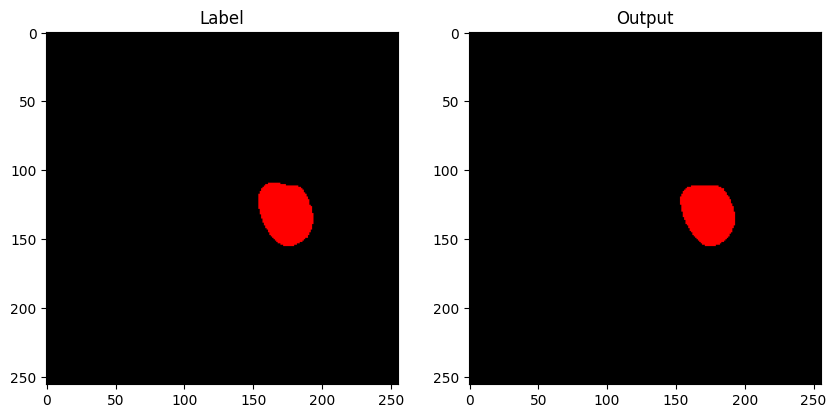

Epoch [30/150] |         Train_loss: 0.0173075560 |         Train_accuracy: 0.3315679140 |         Val_loss: 0.0618486880 |         Val_accuracy: 0.3280263774


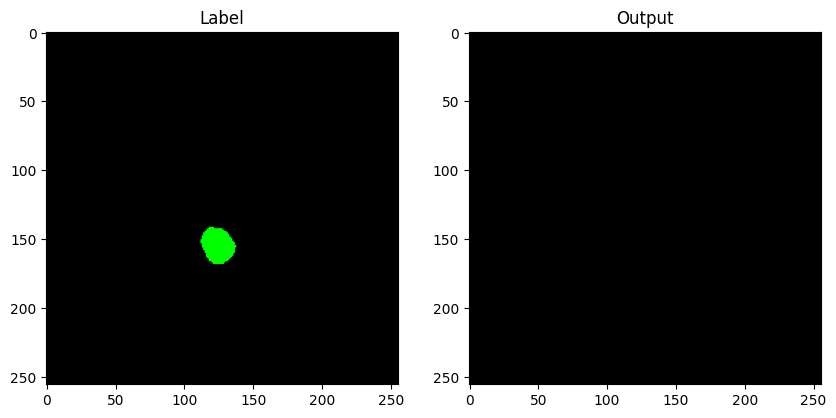

Epoch [31/150] |         Train_loss: 0.0133779233 |         Train_accuracy: 0.3319642639 |         Val_loss: 0.0631585255 |         Val_accuracy: 0.3285277303


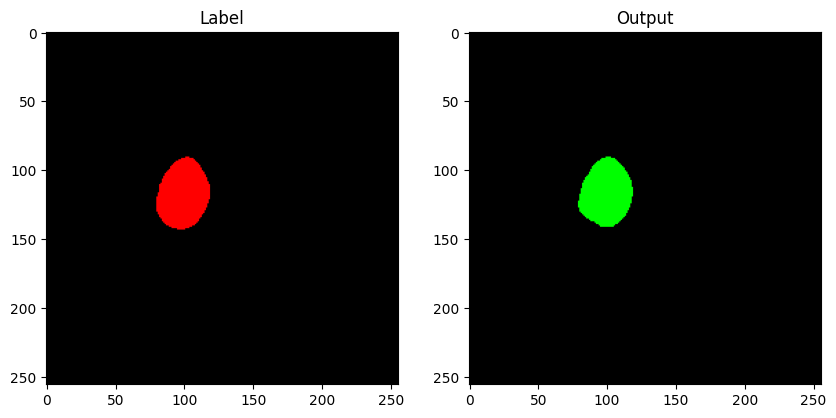

Epoch [32/150] |         Train_loss: 0.0139391226 |         Train_accuracy: 0.3318929376 |         Val_loss: 0.0553850601 |         Val_accuracy: 0.3292153422


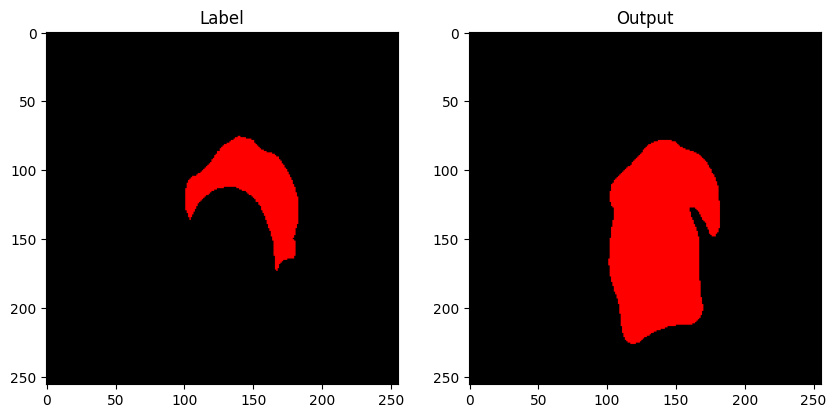

Epoch [33/150] |         Train_loss: 0.0146238290 |         Train_accuracy: 0.3317249665 |         Val_loss: 0.0518289075 |         Val_accuracy: 0.3290078227


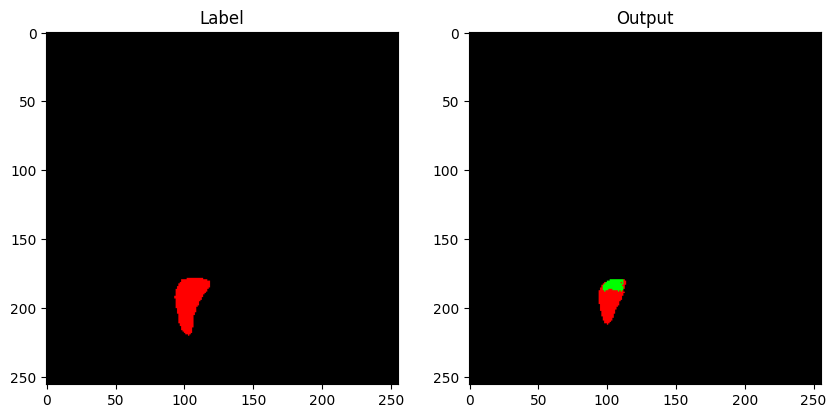

Epoch [34/150] |         Train_loss: 0.0133234253 |         Train_accuracy: 0.3319023584 |         Val_loss: 0.0560016728 |         Val_accuracy: 0.3291010030


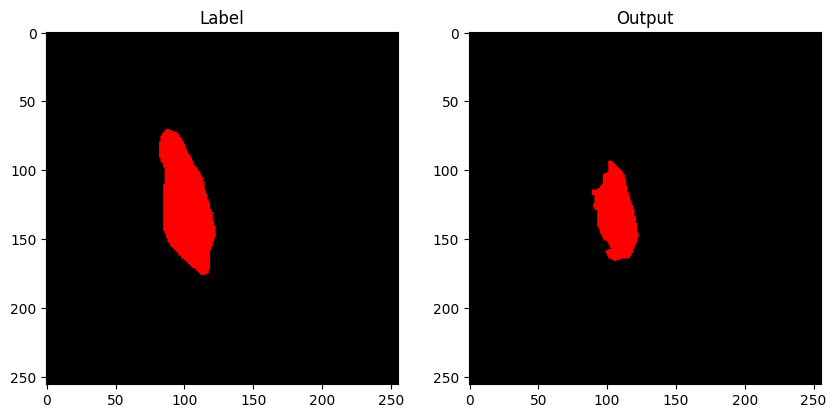

Epoch [35/150] |         Train_loss: 0.0138206223 |         Train_accuracy: 0.3318460196 |         Val_loss: 0.0618065942 |         Val_accuracy: 0.3286330160


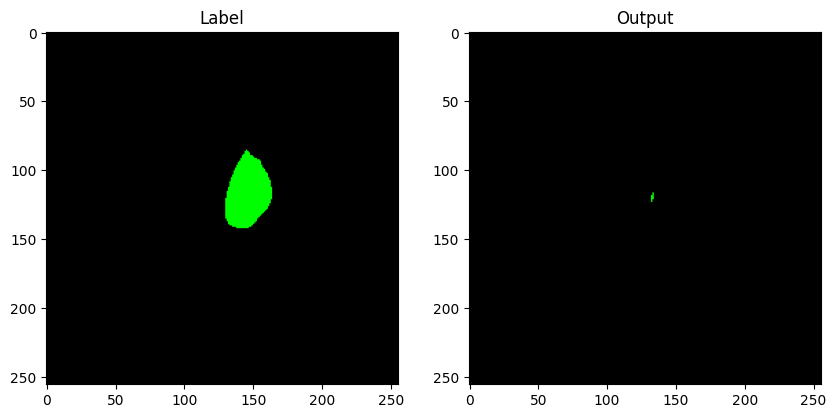

Epoch [36/150] |         Train_loss: 0.0163945429 |         Train_accuracy: 0.3314474770 |         Val_loss: 0.0588575306 |         Val_accuracy: 0.3285962423


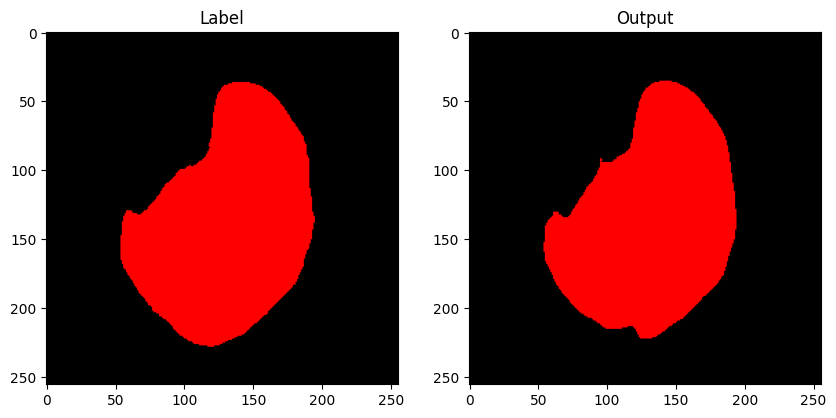

Epoch [37/150] |         Train_loss: 0.0159287134 |         Train_accuracy: 0.3316004548 |         Val_loss: 0.0652436043 |         Val_accuracy: 0.3281850179


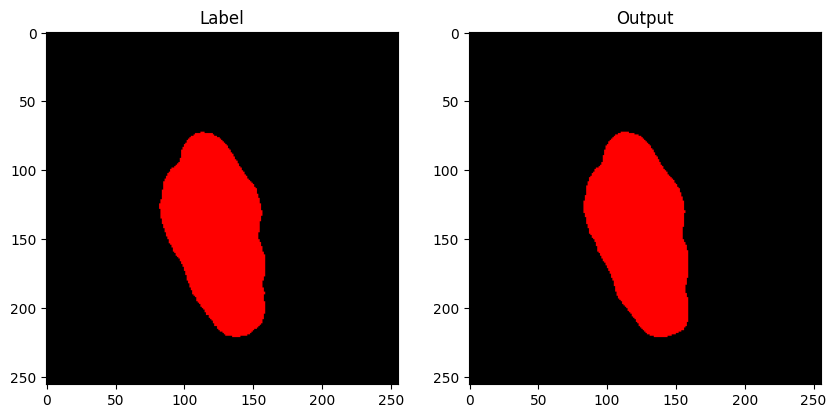

Epoch [38/150] |         Train_loss: 0.0119332088 |         Train_accuracy: 0.3320000034 |         Val_loss: 0.0614849288 |         Val_accuracy: 0.3286236064


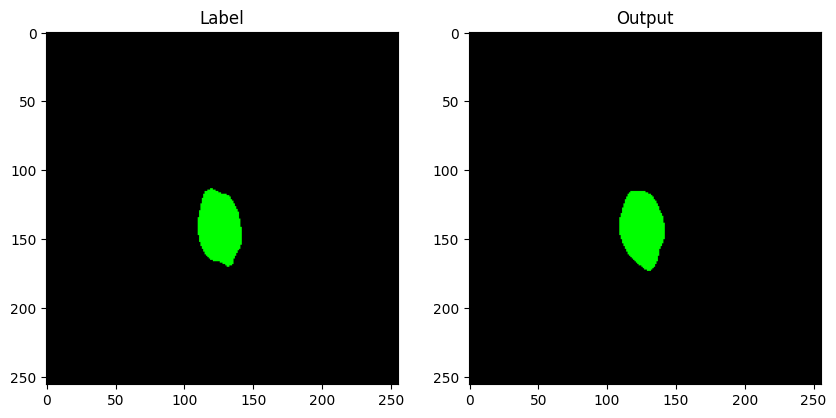

Epoch [39/150] |         Train_loss: 0.0132808194 |         Train_accuracy: 0.3318535586 |         Val_loss: 0.0550511588 |         Val_accuracy: 0.3289832560


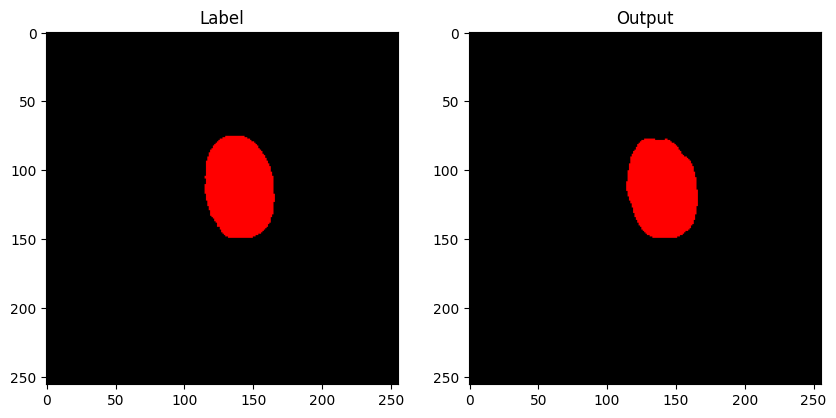

Epoch [40/150] |         Train_loss: 0.0112355691 |         Train_accuracy: 0.3320525558 |         Val_loss: 0.0565276466 |         Val_accuracy: 0.3293127950


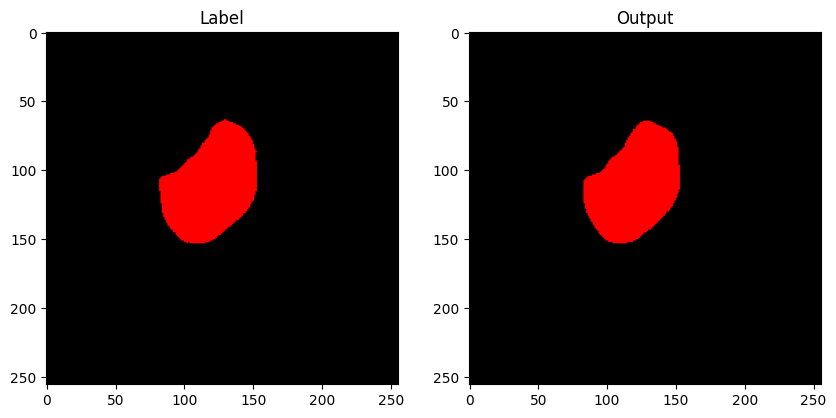

Epoch [41/150] |         Train_loss: 0.0127356599 |         Train_accuracy: 0.3318933218 |         Val_loss: 0.0597880610 |         Val_accuracy: 0.3289107768


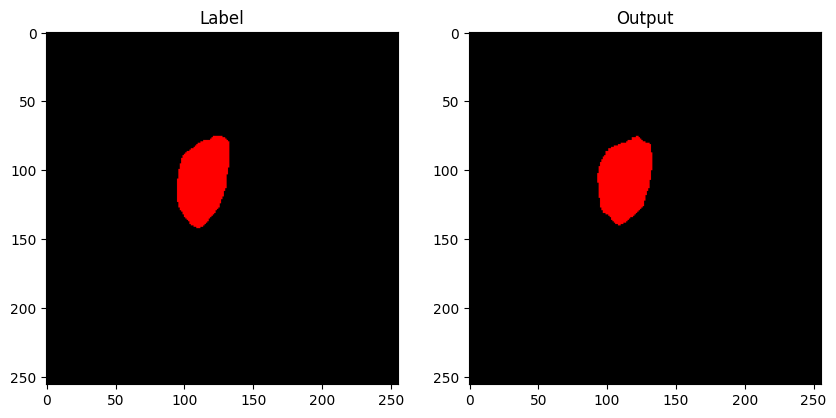

Epoch [42/150] |         Train_loss: 0.0115644572 |         Train_accuracy: 0.3320636269 |         Val_loss: 0.0590901171 |         Val_accuracy: 0.3288744609


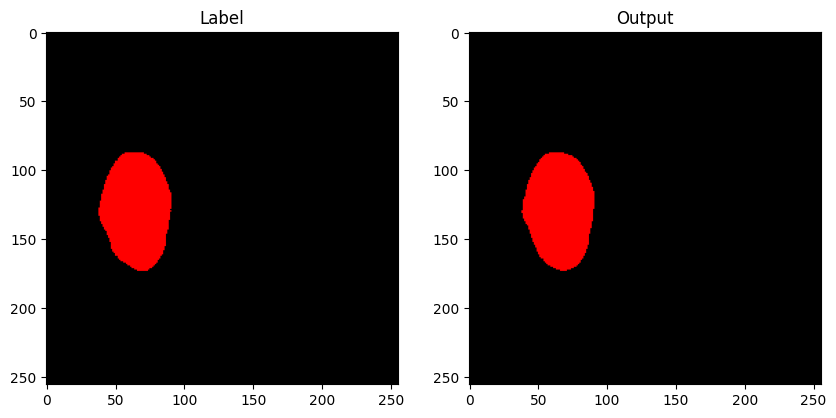

Epoch [43/150] |         Train_loss: 0.0111583127 |         Train_accuracy: 0.3320583654 |         Val_loss: 0.0583182488 |         Val_accuracy: 0.3290578206


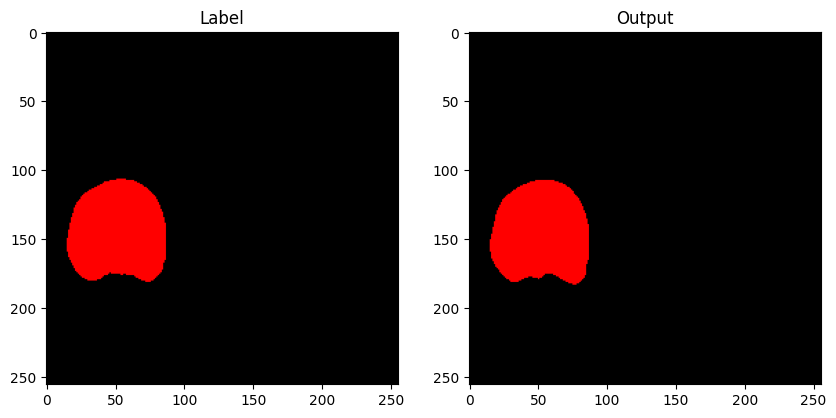

Epoch [44/150] |         Train_loss: 0.0094451606 |         Train_accuracy: 0.3322340789 |         Val_loss: 0.0605622057 |         Val_accuracy: 0.3293595886


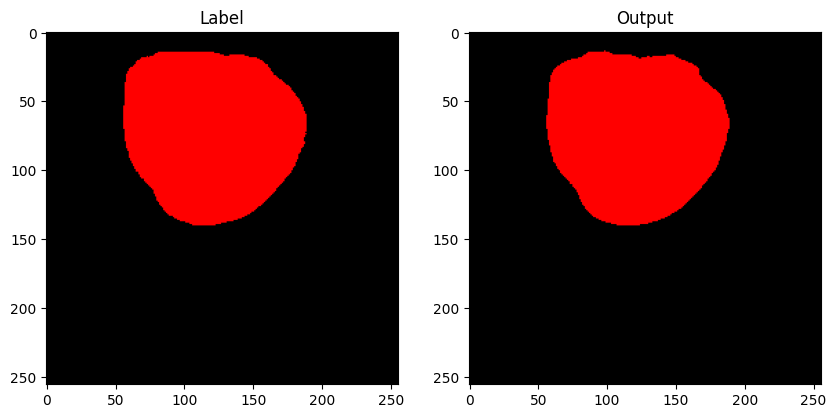

Epoch [45/150] |         Train_loss: 0.0098696431 |         Train_accuracy: 0.3322225387 |         Val_loss: 0.0577823879 |         Val_accuracy: 0.3289990743


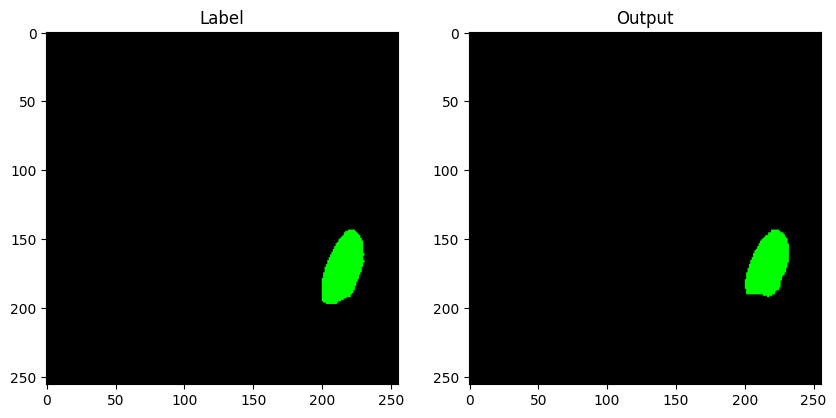

Epoch [46/150] |         Train_loss: 0.0088531860 |         Train_accuracy: 0.3323039867 |         Val_loss: 0.0512244057 |         Val_accuracy: 0.3295680745


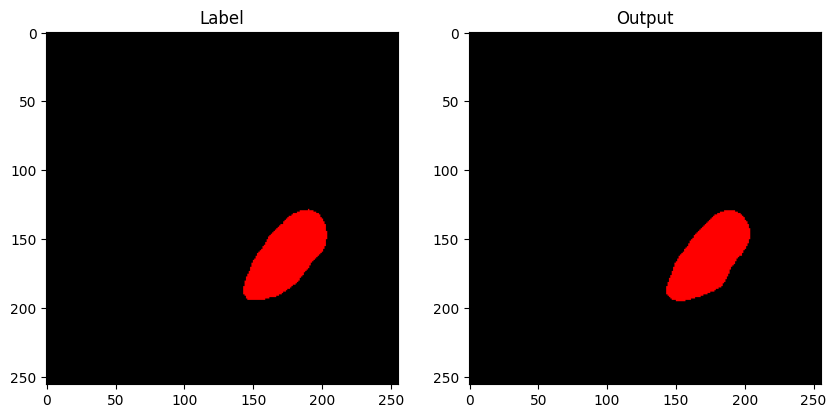

Epoch [47/150] |         Train_loss: 0.0104852471 |         Train_accuracy: 0.3321202483 |         Val_loss: 0.0605352459 |         Val_accuracy: 0.3293612671


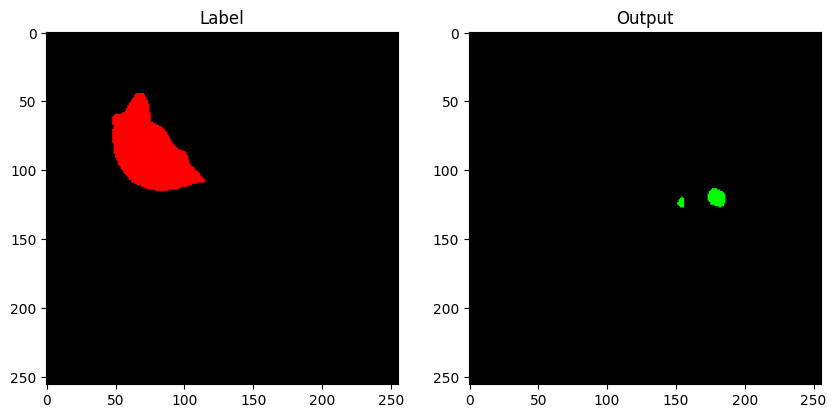

Epoch [48/150] |         Train_loss: 0.0084347756 |         Train_accuracy: 0.3323327750 |         Val_loss: 0.0602753786 |         Val_accuracy: 0.3293357849


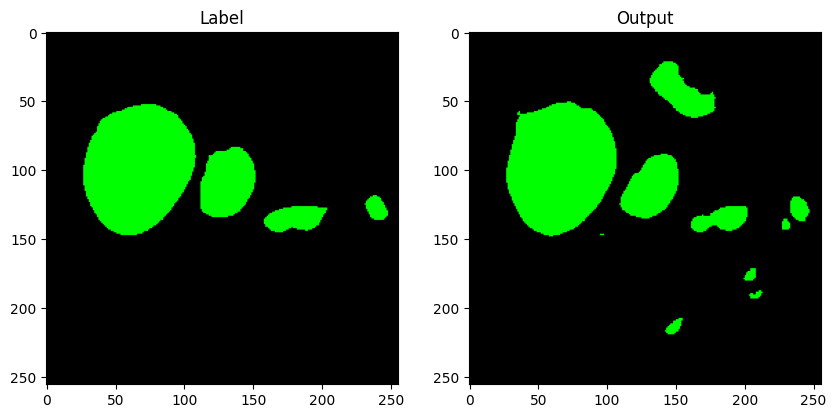

Epoch [49/150] |         Train_loss: 0.0071219229 |         Train_accuracy: 0.3324455487 |         Val_loss: 0.0628522470 |         Val_accuracy: 0.3293723043


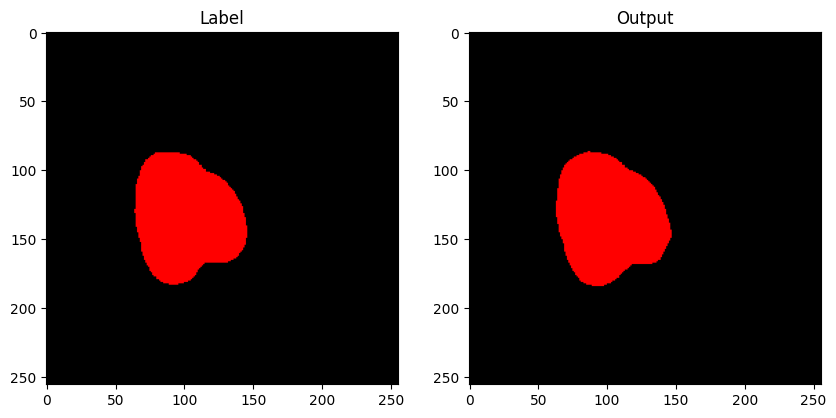

In [ ]:
model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
best_val_loss = 999

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = 0
    train_accuracy = 0
    train_samples = 0
    for images, labels in train_loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
        labels = labels.squeeze(dim=1).long()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Update metrics
        train_loss += loss.item()  # Cộng dồn loss
        
        pred = outputs.argmax(dim=1, keepdim=True)
        train_accuracy += (pred.eq(labels.view_as(pred)).sum().item())/(3*256*256)
        train_samples += labels.size(0)
    train_loss /= len(train_loader)
    train_accuracy /= train_samples
        

    model.eval()
    val_loss = 0
    val_accuracy = 0
    val_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            labels = labels.squeeze(dim=1).long()
            
            outputs = model(images)
            loss = criterion(outputs.float(),labels.long()).item()
            val_loss += loss
            pred = outputs.argmax(dim = 1, keepdim = True)
            val_accuracy += (pred.eq(labels.view_as(pred)).sum().item())/(3*256*256)  # Cộng dồn số dự đoán đúng
            val_samples += labels.size(0)  # Cộng số mẫu trong batch
        val_loss /= len(val_loader)  # Validation loss trung bình
        val_accuracy /= val_samples  # Validation accuracy = số dự đoán đúng / tổng số mẫu
    print(
        f"Epoch [{epoch+1}/{NUM_EPOCHS}] | \
        Train_loss: {train_loss:.10f} | \
        Train_accuracy: {train_accuracy:.10f} | \
        Val_loss: {val_loss:.10f} | \
        Val_accuracy: {val_accuracy:.10f}"
    )

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        save_path = f'/kaggle/working/model.pth'
        torch.save(model.state_dict(), save_path)
        print('New best checkpoint saved!')
    
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "val_loss" : val_loss,
        "val_accuracy" : val_accuracy
    })

    label = labels[1].cpu().numpy()
    label = mask_to_rgb(label,color_dict)
    outputs[1] = outputs[1].softmax(dim=0)
    output = outputs[1].cpu().numpy()
    output = np.argmax(output, axis=0)
    output = mask_to_rgb(output,color_dict)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(label)
    axs[0].set_title('Label')
    axs[1].imshow(output)
    axs[1].set_title('Output')
    plt.show()
wandb.finish()

In [ ]:
checkpoint = torch.load('/kaggle/working/model.pth')
model.load_state_dict(checkpoint)

In [ ]:
! mkdir prediction

In [ ]:
model.eval()
for i in os.listdir("/kaggle/input/polyps-bkai/test/test"):
    img_path = os.path.join("/kaggle/input/polyps-bkai/test/test", i)
    ori_img = cv2.imread(img_path)
    ori_img = cv2.cvtColor(ori_img, cv2.COLOR_BGR2RGB)
    ori_w = ori_img.shape[0]
    ori_h = ori_img.shape[1]
    img = cv2.resize(ori_img, (256, 256))
    transformed = val_transform(image=img)
    input_img = transformed["image"]
    input_img = input_img.unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        output_mask = model(input_img).squeeze(0).cpu().numpy().transpose(1,2,0)
    mask = cv2.resize(output_mask, (ori_h, ori_w))
    mask = np.argmax(mask, axis=2)
    mask_rgb = mask_to_rgb(mask, color_dict)
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_RGB2BGR)
    cv2.imwrite("prediction/{}".format(i), mask_rgb)

In [ ]:
import numpy as np
import pandas as pd
import cv2
import os

def rle_to_string(runs):
    return ' '.join(str(x) for x in runs)

def rle_encode_one_mask(mask):
    pixels = mask.flatten()
    pixels[pixels > 225] = 255
    pixels[pixels <= 225] = 0
    use_padding = False
    if pixels[0] or pixels[-1]:
        use_padding = True
        pixel_padded = np.zeros([len(pixels) + 2], dtype=pixels.dtype)
        pixel_padded[1:-1] = pixels
        pixels = pixel_padded
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 2
    if use_padding:
        rle = rle - 1
    rle[1::2] = rle[1::2] - rle[:-1:2]
    
    return rle_to_string(rle)

def rle2mask(mask_rle, shape=(3,3)):
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T

def mask2string(dir):
    strings = []
    ids = []
    ws, hs = [[] for i in range(2)]
    for image_id in os.listdir(dir):
        id = image_id.split('.')[0]
        path = os.path.join(dir, image_id)
        print(path)
        img = cv2.imread(path)[:,:,::-1]
        h, w = img.shape[0], img.shape[1]
        for channel in range(2):
            ws.append(w)
            hs.append(h)
            ids.append(f'{id}_{channel}')
            string = rle_encode_one_mask(img[:,:,channel])
            strings.append(string)
    r = {
        'ids': ids,
        'strings': strings,
    }
    return r


MASK_DIR_PATH = r'/kaggle/working/prediction'
dir = MASK_DIR_PATH
res = mask2string(dir)
df = pd.DataFrame(columns=['Id', 'Expected'])
df['Id'] = res['ids']
df['Expected'] = res['strings']

df.to_csv(r'test_mask_result.csv', index=False)
print('Finish')